In [145]:
import numpy as np 
import pandas as pd 
import ast
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageOps
from sklearn.model_selection  import train_test_split
import torch
from torch import nn
from collections import OrderedDict
from torch import optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# step 1

In [146]:
categories = ['apple','banana']
label_dict = {0:'apple',1:'banana'}

# load data for each category
classes = {}
for category in categories:
    data = pd.read_csv("/Users/w2/Downloads/" +category + ".csv")
    classes[category] = data

In [147]:
# Image manipulation utilities: 

def convert_to_PIL(drawing, width = 256, height = 256):

    
    # init
    pil_img = Image.new('RGB', (width, height), 'white')
    pixels = pil_img.load()
            
    draw = ImageDraw.Draw(pil_img)
    
    # draw strokes as lines
    for x,y in drawing:
        for i in range(1, len(x)):
            draw.line((x[i-1], y[i-1], x[i], y[i]), fill=0)
        
    return pil_img

def convert_to_np_raw(drawing, width = 256, height = 256):

    # init array
    img = np.zeros((28, 28))
    
    # create a PIL image out of drawing
    pil_img = convert_to_PIL(drawing)
    
    #resize to 28,28
    pil_img.thumbnail((28,28), Image.ANTIALIAS)
    
    pil_img = pil_img.convert('RGB')
    pixels = pil_img.load()
    
    # fill in numpy array with pixel values
    for i in range(0, 28):
        for j in range(0, 28):
            img[i, j] = 1 - pixels[j, i][0] / 255
    
    return img



def view_image(img, width = 256, height = 256):
    fig, ax = plt.subplots(figsize=(6,9))
    ax.imshow(img.reshape(width, height).squeeze())
    ax.axis('off')

    plt.show()

In [148]:
values_dict = {}
for category in categories:
    data = classes[category][:3000]
    values = [convert_to_np_raw(ast.literal_eval(img)).reshape(1, 784) for img in data['drawing'].values]
    values_dict[category] = values
    

X = []
y = []

for key, value in label_dict.items():
    data_i = values_dict[value]
    Xi = np.concatenate(data_i, axis = 0)
    yi = np.full((len(Xi), 1), key).ravel()
    
    X.append(Xi)
    y.append(yi)
    
X = np.concatenate(X, axis = 0)
y = np.concatenate(y, axis = 0)

In [149]:
def view_images_grid(X, y):

    fig, axs = plt.subplots(5, 5, figsize=(50,50))
    
    for label_num in range(0,25):
        r_label = random.randint(0, len(X) - 1)
        image = X[r_label].reshape(28,28)  #reshape images
        i = label_num // 5
        j = label_num % 5
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
        
        axs[i,j].set_title( label_dict[y[r_label]] ,fontsize=50)

    plt.show()

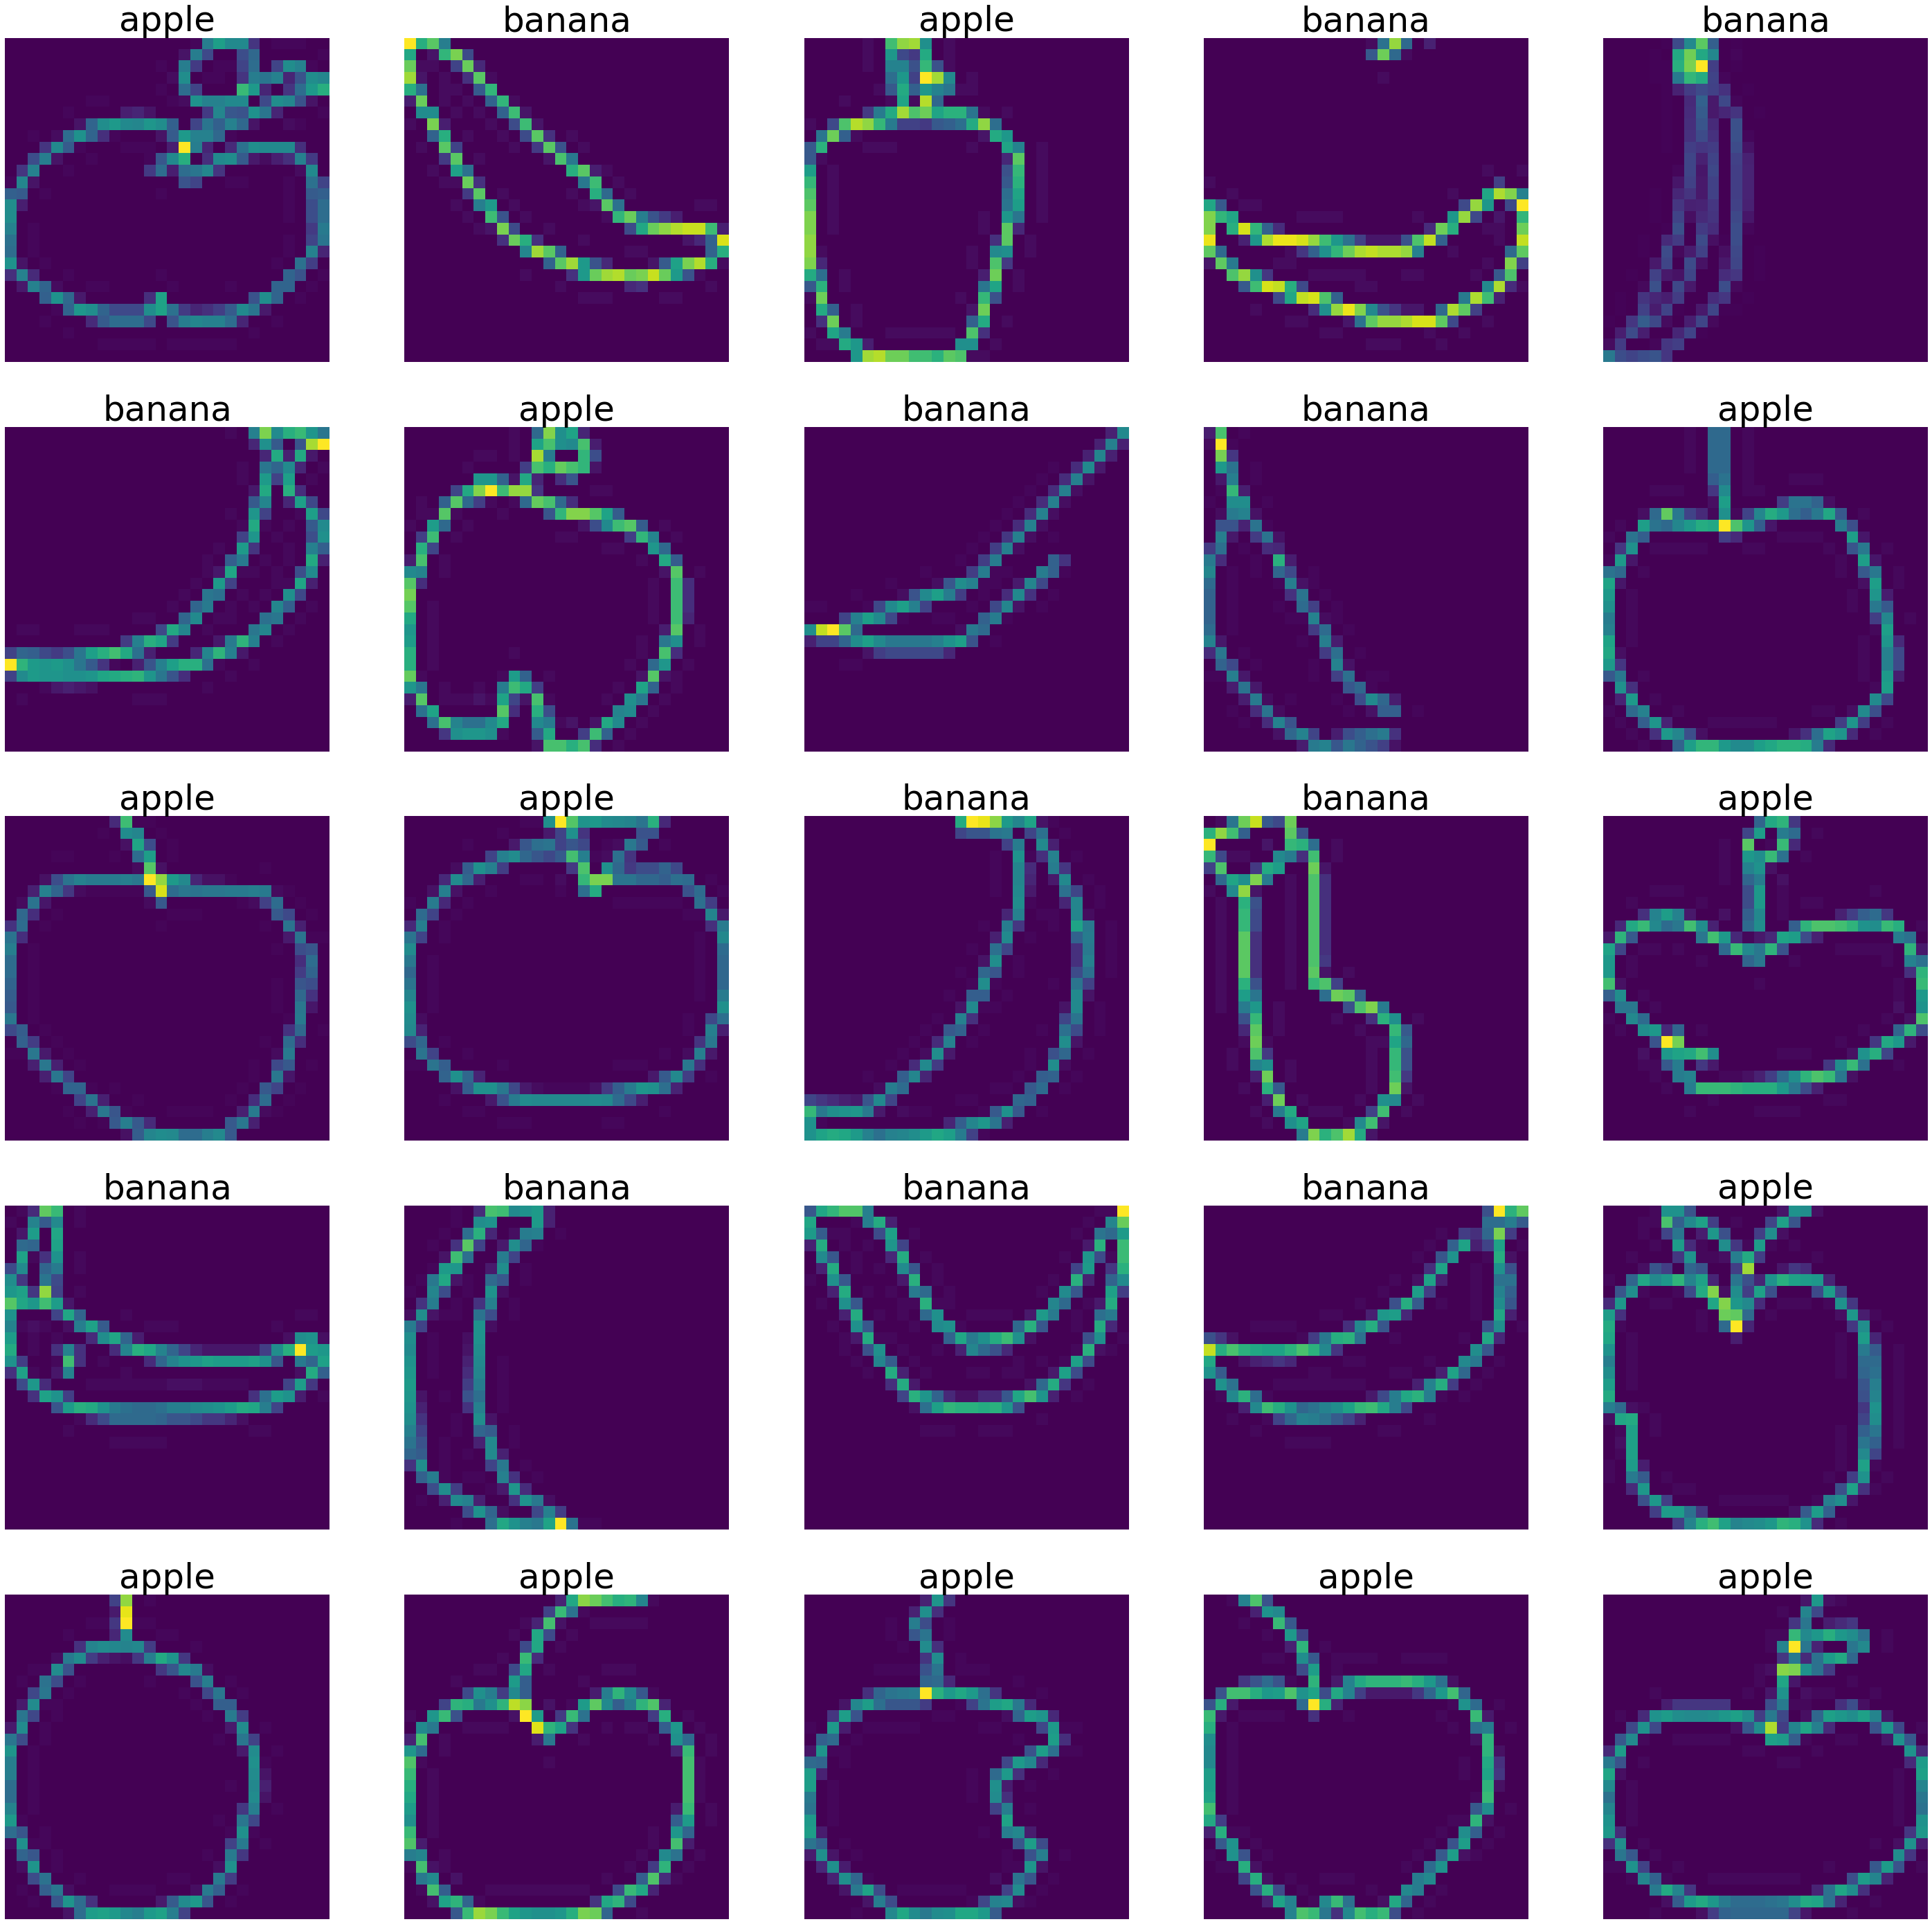

In [150]:
view_images_grid(X, y)

In [151]:
def npToImage(img):
    img_r = img.reshape(28,28)

    pil_img = Image.new('RGB', (28, 28), 'white')
    pixels = pil_img.load()

    for i in range(0, 28):
        for j in range(0, 28):
            if img_r[i, j] > 0:
                pixels[j, i] = (255 - int(img_r[i, j] * 255), 255 - int(img_r[i, j] * 255), 255 - int(img_r[i, j] * 255))

    return pil_img


def toNp(pil_img, width = 256, height = 256):
    pil_img = pil_img.convert('RGB')

    img = np.zeros((width, height))
    pixels = pil_img.load()

    for i in range(0, width):
        for j in range(0, height):
            img[i, j] = 1 - pixels[j, i][0] / 255

    return img

def flip(src_im):
    dst_im = src_im.transpose(Image.FLIP_LEFT_RIGHT)
    return dst_im


def rotate(src_im, angle = 45, size = (28,28)):
    dst_im = Image.new("RGBA", size, "white")
    src_im = src_im.convert('RGBA')

    rot = src_im.rotate(angle)
    dst_im.paste(rot, (0, 0), rot)

    return dst_im


(-0.5, 27.5, 27.5, -0.5)

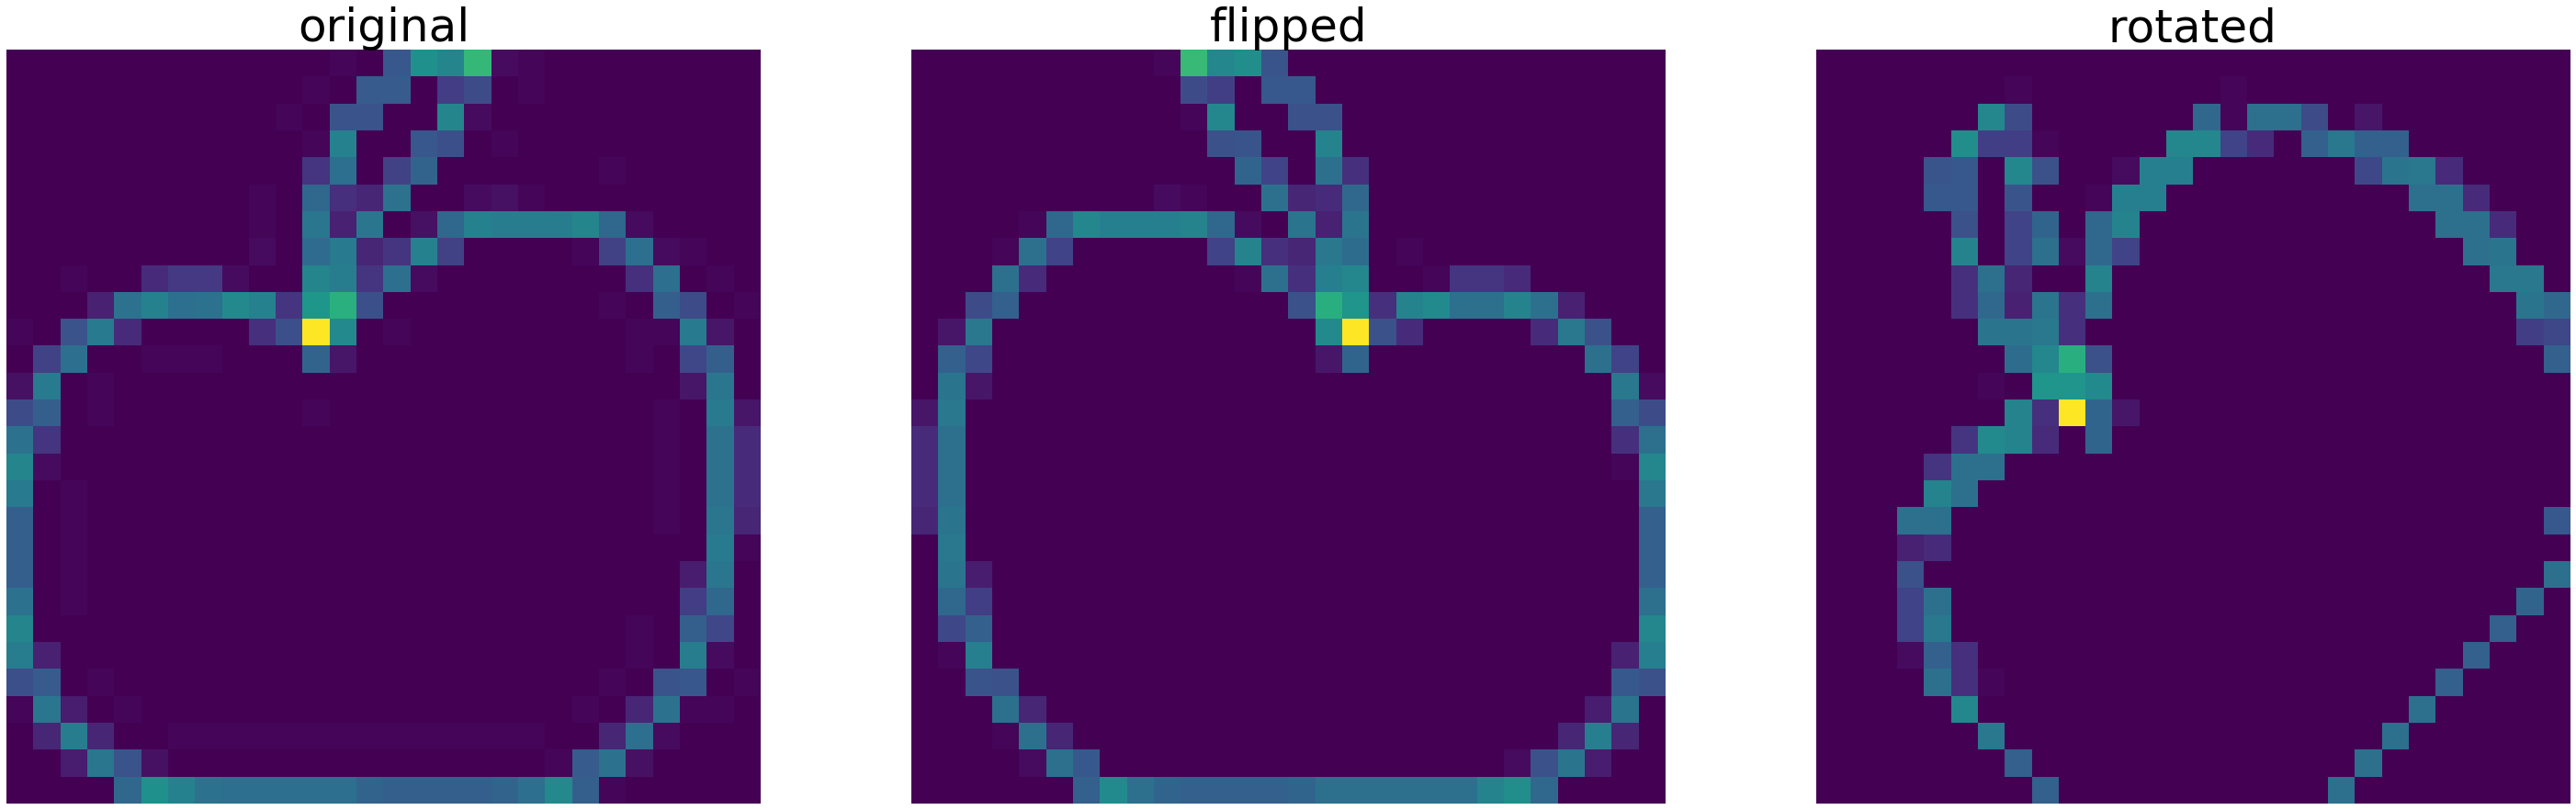

In [152]:
fig, axs = plt.subplots(1,3, figsize=(50,50))

np_img = X[100]
np_img_flipped = toNp(flip(npToImage(np_img)), 28, 28)
np_img_rotated = toNp(rotate(npToImage(np_img)), 28, 28)

axs[0].set_title('original', fontsize = 50)
axs[0].imshow(np_img.reshape(28, 28).squeeze())
axs[0].axis('off')

axs[1].set_title('flipped', fontsize = 50)
axs[1].imshow(np_img_flipped.reshape(28, 28).squeeze())
axs[1].axis('off')

axs[2].set_title('rotated', fontsize = 50)
axs[2].imshow(np_img_rotated.reshape(28, 28).squeeze())
axs[2].axis('off')

# step 2

In [153]:
def build_model(input_size, output_size, hidden_sizes, dropout = 0.0):

    model = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                          ('bn2', nn.BatchNorm1d(num_features=hidden_sizes[1])),
                          ('relu2', nn.ReLU()),
                          ('dropout', nn.Dropout(dropout)),
                          ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                          ('bn3', nn.BatchNorm1d(num_features=hidden_sizes[2])),
                          ('relu3', nn.ReLU()),
                          ('logits', nn.Linear(hidden_sizes[2], output_size))]))

    return model

def fit_model(model, X_train, y_train, epochs = 100, n_chunks = 1000, learning_rate = 0.003, weight_decay = 0, optimizer = 'SGD'):

    print("Fitting model with epochs = {epochs}, learning rate = {lr}\n"\
          .format(epochs = epochs, lr = learning_rate))

    criterion = nn.CrossEntropyLoss()

    if (optimizer == 'SGD'):
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)

    print_every = 10

    steps = 0

    for e in range(epochs):
        running_loss = 0

        X_train, y_train = shuffle(X_train, y_train)

        images = torch.chunk(X_train, n_chunks)
        labels = torch.chunk(y_train, n_chunks)

        for i in range(n_chunks):
            steps += 1

            optimizer.zero_grad()

            output = model.forward(images[i])
            loss = criterion(output, labels[i].squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        if epochs % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))

            running_loss = 0
                

In [154]:
def get_preds(model, input):
    
    with torch.no_grad():
        logits = model.forward(input)
    ps = F.softmax(logits, dim=1)
    return ps

def get_labels(pred):
    pred_np = pred.numpy()
    pred_values = np.amax(pred_np, axis=1, keepdims=True)
    pred_labels = np.array([np.where(pred_np[i, :] == pred_values[i, :])[0] for i in range(pred_np.shape[0])])
    pred_labels = pred_labels.reshape(len(pred_np), 1)

    return pred_labels

def evaluate_model(model, train, y_train, test, y_test):
    train_pred = get_preds(model, train)
    train_pred_labels = get_labels(train_pred)

    test_pred = get_preds(model, test)
    test_pred_labels = get_labels(test_pred)

    accuracy_train = accuracy_score(y_train, train_pred_labels)
    accuracy_test = accuracy_score(y_test, test_pred_labels)

    print("Accuracy score for train set is {} \n".format(accuracy_train))
    print("Accuracy score for test set is {} \n".format(accuracy_test))

    return accuracy_train, accuracy_test

def shuffle(X_train, y_train):
    X_train_shuffled = X_train.numpy()
    y_train_shuffled = y_train.numpy().reshape((X_train.shape[0], 1))

    permutation = list(np.random.permutation(X_train.shape[0]))
    X_train_shuffled = X_train_shuffled[permutation, :]
    y_train_shuffled = y_train_shuffled[permutation, :].reshape((X_train.shape[0], 1))

    X_train_shuffled = torch.from_numpy(X_train_shuffled).float()
    y_train_shuffled = torch.from_numpy(y_train_shuffled).long()

    return X_train_shuffled, y_train_shuffled

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [156]:
train = torch.from_numpy(X_train).float()
labels = torch.from_numpy(y_train).long()
test = torch.from_numpy(X_test).float()
test_labels = torch.from_numpy(y_test).long()

input_size = 784
hidden_sizes = [128, 100, 64]
output_size = 2

dropout = 0.0
weight_decay = 0.0
n_chunks = 700
learning_rate = 0.03
optimizer = 'SGD'

In [157]:
train_acc = []
test_acc = []

for epochs in np.arange(10, 60, 10):
    model = build_model(input_size, output_size, hidden_sizes, dropout = dropout)

    fit_model(model, train, labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay, optimizer = 'SGD')
    accuracy_train, accuracy_test = evaluate_model(model, train, y_train, test, y_test)

    train_acc.append(accuracy_train)
    test_acc.append(accuracy_test)

Fitting model with epochs = 10, learning rate = 0.03

Epoch: 1/10...  Loss: 18.3708
Epoch: 2/10...  Loss: 14.6232
Epoch: 3/10...  Loss: 11.3009
Epoch: 4/10...  Loss: 9.8394
Epoch: 5/10...  Loss: 10.3966
Epoch: 6/10...  Loss: 8.5688
Epoch: 7/10...  Loss: 7.8209
Epoch: 8/10...  Loss: 7.2876
Epoch: 9/10...  Loss: 6.7137
Epoch: 10/10...  Loss: 6.5601
Accuracy score for train set is 0.9978571428571429 

Accuracy score for test set is 0.9705555555555555 

Fitting model with epochs = 20, learning rate = 0.03

Epoch: 1/20...  Loss: 19.2919
Epoch: 2/20...  Loss: 13.9009
Epoch: 3/20...  Loss: 11.9942
Epoch: 4/20...  Loss: 10.4232
Epoch: 5/20...  Loss: 9.1027
Epoch: 6/20...  Loss: 9.6393
Epoch: 7/20...  Loss: 8.5560
Epoch: 8/20...  Loss: 7.8092
Epoch: 9/20...  Loss: 6.8130
Epoch: 10/20...  Loss: 6.6301
Epoch: 11/20...  Loss: 5.6078
Epoch: 12/20...  Loss: 6.2278
Epoch: 13/20...  Loss: 7.6717
Epoch: 14/20...  Loss: 6.1784
Epoch: 15/20...  Loss: 5.7525
Epoch: 16/20...  Loss: 6.2173
Epoch: 17/20...  